In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt

from sklearn import set_config

pd.options.display.max_rows = 150

set_config(display="diagram")
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import TransformerMixin, BaseEstimator

from itertools import combinations

from sklearn.decomposition import PCA

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
)

from sklearn.model_selection import train_test_split

from joblib import dump, load

#https://analyticsindiamag.com/7-types-classification-algorithms/
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
)
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (f1_score,precision_score,accuracy_score,recall_score)
from sklearn.metrics import confusion_matrix,classification_report

                                
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.max_columns = 100
sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [2]:
# ouverture du dataframe
input_path = r'C:\\Users\\alojou\\Notebook Python\\Projet_7 Modèle de scoring\\input\\df_train.csv'

In [3]:
def transform_numerical_to_categorical(df):
    
    category_features = []
    threshold = 2
    for each in df.columns:
        if df[each].nunique() <= threshold:
            category_features.append(each)

    print("transformed from numerical to categorical : ",category_features)   


    for each in category_features:
        df[each] = df[each].astype('category')

    obj_col = df.select_dtypes("object").columns
    for each in obj_col:
        df[each] = df[each].astype('category')
    
    return df 

In [4]:
def my_train_test_split(data):
    
    # train test split
    target = data['TARGET'].astype('int')
    data.drop(columns = ['TARGET'], inplace = True)
    
        
    x_train, x_test, y_train, y_test = train_test_split(data,target, train_size=0.5, random_state = 42)

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    return  x_train, x_test, y_train, y_test
    

In [5]:
def processed_data(df):
    # definition des transformers

    #ss = MinMaxScaler()
    ss = StandardScaler()
    #pca = PCA(n_components="mle")


    # definition des groupes de feature qui vont subir les même transformation
    cat_vars = df.select_dtypes("category").columns
    num_vars = df.select_dtypes(include=np.number).columns


    # Creation des pipeline de transformation
    numeric_pipe = Pipeline([("ss", ss)])


    # Creation des columnTransformer
    col_transformer = ColumnTransformer(
        transformers=[
            ("nums", numeric_pipe, num_vars),
            #("cats", numeric_pipe, cat_vars),
            ('columns_to_keep', "passthrough", cat_vars)
        ],
        remainder="drop",
        n_jobs=None,
    )
    # creation de différent pipe pour trouver la meilleur combinaison
    data_pipe = Pipeline([("col_transformer", col_transformer)])
    #data_pipe_PCA = Pipeline([("col_transformer", col_transformer,("pca", pca))])
    
    return data_pipe

In [6]:
def prepare_data_for_modelisation(input_path):
    
    df = pd.read_csv(input_path)
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    df.drop(columns = nan_cols, inplace = True)
    df = df.loc[:,~df.columns.str.startswith('Unnamed')]
    df = df[df['TARGET'].notnull()]
    df.drop(columns = ['SK_ID_CURR','index'], inplace = True)
    
    df = transform_numerical_to_categorical(df)
    
    x_train, x_test, y_train, y_test = my_train_test_split(df)
    
    data_pipe = processed_data(x_train)
    
    return x_train, x_test, y_train, y_test, data_pipe

In [7]:
x_train, x_test, y_train, y_test, data_pipe = prepare_data_for_modelisation(input_path)

transformed from numerical to categorical :  ['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Sp

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

#very imbalanced data

{0: 141369, 1: 12384}

In [10]:
def selection_modele(x_train, y_train,x_test, y_test, data_pipe, c_weight = None):
    
    model = {'LR' : LogisticRegression(class_weight = c_weight),
            'SGD' : SGDClassifier(class_weight = c_weight),
            'RFR' : RandomForestClassifier(class_weight = c_weight),
            'XGB' : XGBClassifier(scoring='roc_auc')
            }

    for k,v in model.items():
        pipe = Pipeline(
            [
                ("data_pipe", data_pipe),
                ("clf", v),
            ]
        )
        pipe.fit(x_train, y_train)

        # prediction
        y_pred = np.array(pipe.predict(x_test))

        # scoring
        print(F"scoring du modèle : {v} \n")
        print(classification_report(y_test, y_pred),"\n")

        df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
        plt.figure(figsize=(10,7))
        sns.set(font_scale=1.4) # for label size
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

        plt.show()
        print("\n")

# Choix de la methode d'entrainement

### Class_weight

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


scoring du modèle : LogisticRegression(class_weight='balanced') 

              precision    recall  f1-score   support

           0       0.96      0.71      0.82    141313
           1       0.17      0.69      0.28     12441

    accuracy                           0.71    153754
   macro avg       0.57      0.70      0.55    153754
weighted avg       0.90      0.71      0.77    153754
 



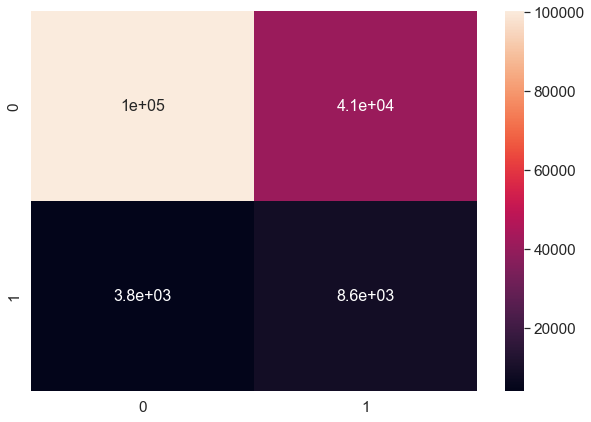



scoring du modèle : SGDClassifier(class_weight='balanced') 

              precision    recall  f1-score   support

           0       0.96      0.66      0.78    141313
           1       0.15      0.67      0.24     12441

    accuracy                           0.66    153754
   macro avg       0.55      0.67      0.51    153754
weighted avg       0.89      0.66      0.74    153754
 



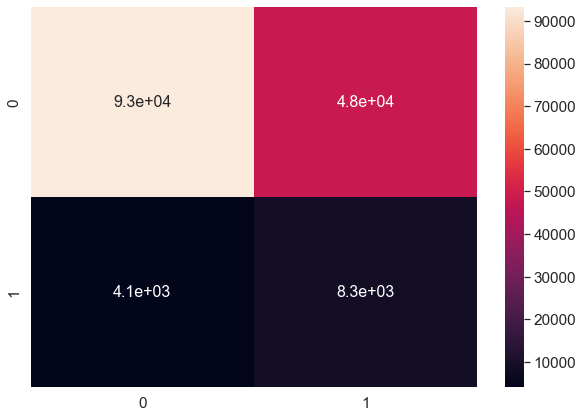



scoring du modèle : RandomForestClassifier(class_weight='balanced') 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    141313
           1       0.59      0.00      0.00     12441

    accuracy                           0.92    153754
   macro avg       0.76      0.50      0.48    153754
weighted avg       0.89      0.92      0.88    153754
 



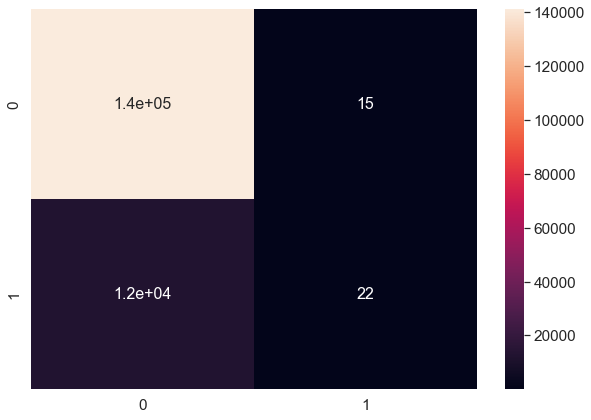

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
scoring du modèle : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learnin

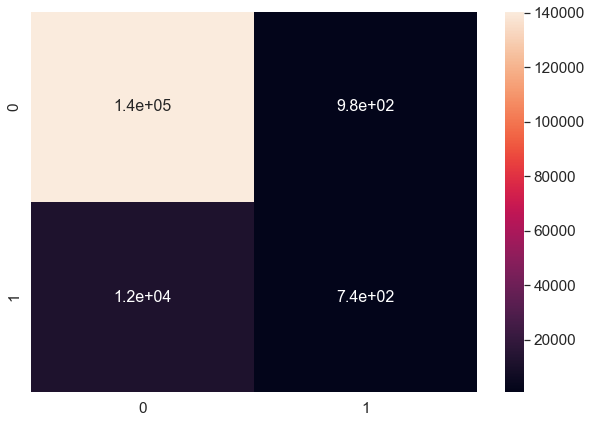

In [25]:
selection_modele(x_train, y_train, x_test, y_test, data_pipe, c_weight = 'balanced')

### random under sampling

In [26]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(x_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 141369, 1: 12384})
Resample dataset shape Counter({0: 12384, 1: 12384})


c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


scoring du modèle : LogisticRegression() 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    141313
           1       0.17      0.70      0.27     12441

    accuracy                           0.70    153754
   macro avg       0.57      0.70      0.54    153754
weighted avg       0.90      0.70      0.77    153754
 



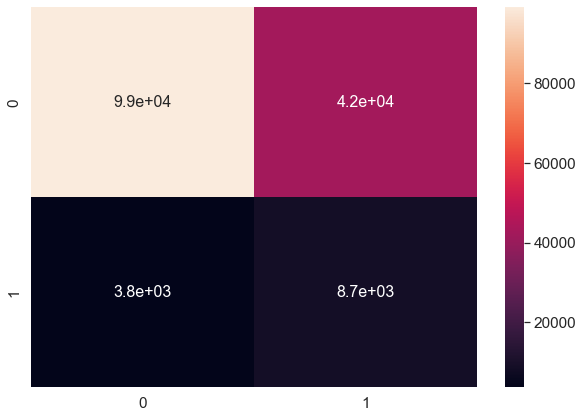



scoring du modèle : SGDClassifier() 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    141313
           1       0.16      0.63      0.25     12441

    accuracy                           0.69    153754
   macro avg       0.56      0.66      0.53    153754
weighted avg       0.89      0.69      0.76    153754
 



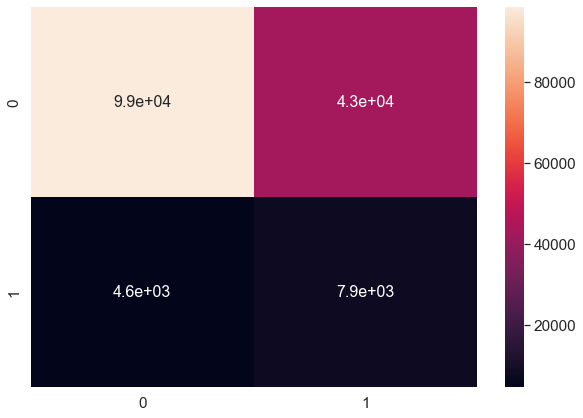



scoring du modèle : RandomForestClassifier() 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79    141313
           1       0.15      0.68      0.25     12441

    accuracy                           0.67    153754
   macro avg       0.56      0.67      0.52    153754
weighted avg       0.89      0.67      0.75    153754
 



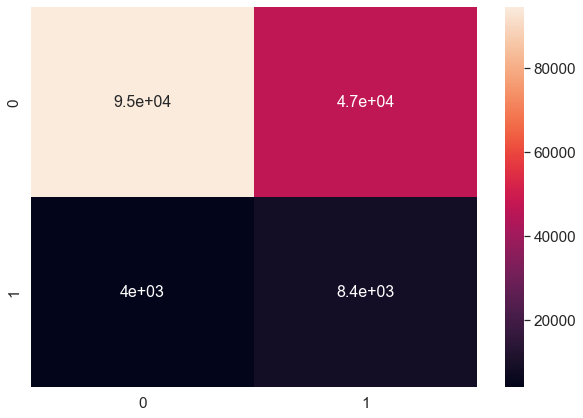

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
selection_modele(x_rus, y_rus, x_test, y_test, data_pipe, c_weight = None)

In [ ]:
del x_rus
del y_rus

### SMOTE

In [11]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

# fit predictor and target variable
x_smote, y_smote = sm.fit_resample(np.array(x_train), y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 141369, 1: 12384})
Resample dataset shape Counter({0: 141369, 1: 141369})


In [12]:
x_smote = pd.DataFrame(columns = x_train.columns, data = x_smote)
del x_train

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


scoring du modèle : LogisticRegression() 

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    141313
           1       0.18      0.69      0.28     12441

    accuracy                           0.71    153754
   macro avg       0.57      0.70      0.55    153754
weighted avg       0.90      0.71      0.78    153754
 



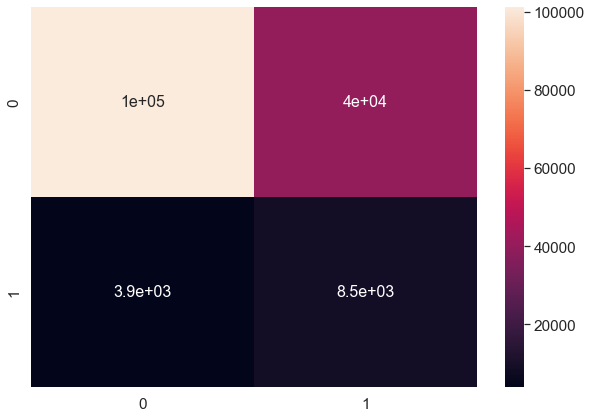



scoring du modèle : SGDClassifier() 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81    141313
           1       0.17      0.67      0.27     12441

    accuracy                           0.70    153754
   macro avg       0.56      0.69      0.54    153754
weighted avg       0.90      0.70      0.77    153754
 



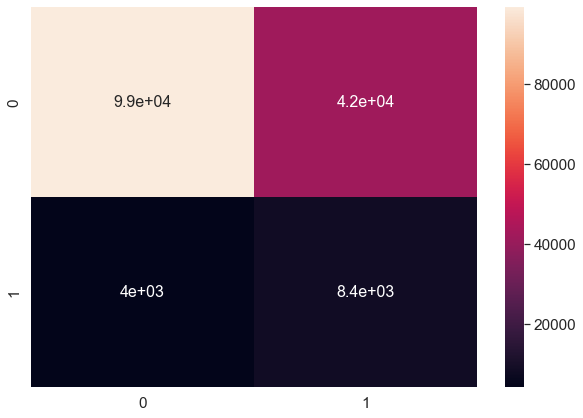



scoring du modèle : RandomForestClassifier() 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    141313
           1       0.45      0.01      0.01     12441

    accuracy                           0.92    153754
   macro avg       0.69      0.50      0.48    153754
weighted avg       0.88      0.92      0.88    153754
 



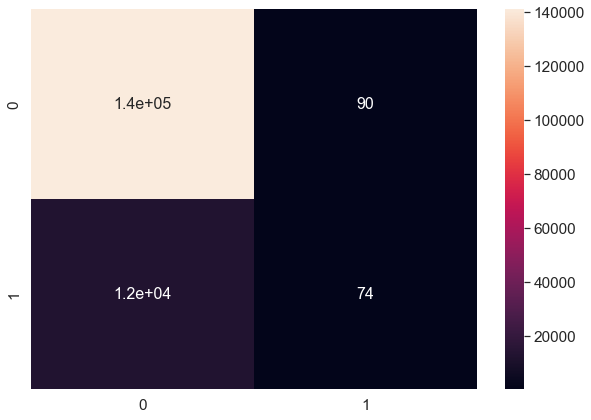

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:24:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
scoring du modèle : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learnin

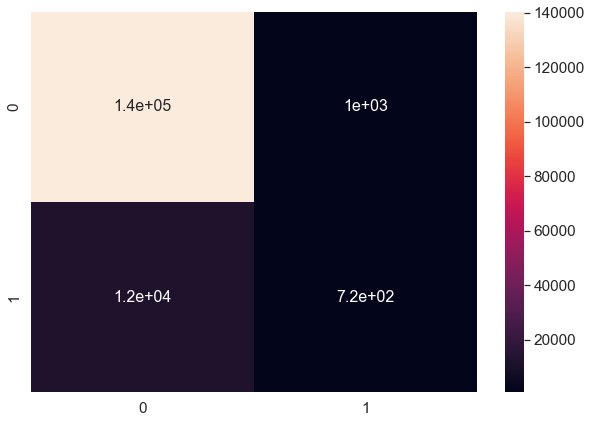

In [13]:
selection_modele(x_smote, y_smote, x_test, y_test, data_pipe, c_weight = None)

In [14]:
del x_smote
del y_smote

# choix modele lr 

### feature importance

In [9]:
# definition des transformers

# revoir les scaler 
# modele , variable 

ss = MinMaxScaler()
pca = PCA()


# definition des groupes de feature qui vont subir les même transformation
cat_vars = x_train.select_dtypes("category").columns
num_vars = x_train.select_dtypes(include=np.number).columns


# Creation des pipeline de transformation
numeric_pipe = Pipeline([("ss", ss)])


# Creation des columnTransformer
col_transformer = ColumnTransformer(
    transformers=[
        ("nums", numeric_pipe, num_vars),
        #("cats", numeric_pipe, cat_vars),
        ('columns_to_keep', "passthrough",cat_vars )
    ],
    remainder="drop",
    n_jobs=-1,
)

# creation de différent pipe pour trouver la meilleur combinaison

pipe = Pipeline(
            [
                ("col_transformer", col_transformer),
                #("pca", pca),
                #("clf",  LogisticRegression(solver='liblinear', class_weight = 'balanced')),
            ]
        )

In [10]:
pipe.fit(x_train, y_train)
model = LogisticRegression(solver='liblinear', class_weight = 'balanced')
model.fit(pipe.transform(x_train),y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [20]:
# Get the coefficients of each feature
importance = model.coef_[0]
data = []

for i,v in enumerate(importance):
    print(v)
    data.append(v)

df_importance = pd.DataFrame(index = [x_train.columns],columns = ["feature_importance"] , data = data)
df_importance["feature_importance"] = df_importance["feature_importance"].apply(lambda x : np.abs(x))

0.3199887034469963
2.317292776340052
3.4842358902999284
3.603623787827746
-6.432297888895485
0.1108051670838241
0.20460831157905543
0.12229260602597444
0.14881679040371196
0.3084227076031358
0.7747079930466102
0.2692022244885613
-0.05188575452575004
0.37502655224374726
0.0761209288649842
-3.1775372613510062
-1.7108251910464771
-1.986854043137408
1.2537874359808059
-1.5583125237603939
1.652348369686693
0.4428495309699381
-0.10290232366741389
-0.3137304222320115
0.3637612916357056
0.5981152308257988
0.26221298471388765
0.5224167151459006
-0.3914439126278971
0.7314489474359673
-0.3745905748931437
0.8133719228581977
0.0557332527256324
0.7758947735292132
-0.8606503400560461
-0.7330909907520872
0.5393563521186655
1.754431962178188
-1.2689678699458393
-0.33994504036257067
-0.26267606993910264
-0.7296288143615204
0.1458146544143769
-1.2011754296429897
0.7861427850421077
-1.1538776451576798
-0.5043623229689792
0.6513000024431218
-0.4438105578665494
-0.5530828268281526
-0.3836949069213592
-1.481

In [21]:
data

[0.3199887034469963,
 2.317292776340052,
 3.4842358902999284,
 3.603623787827746,
 -6.432297888895485,
 0.1108051670838241,
 0.20460831157905543,
 0.12229260602597444,
 0.14881679040371196,
 0.3084227076031358,
 0.7747079930466102,
 0.2692022244885613,
 -0.05188575452575004,
 0.37502655224374726,
 0.0761209288649842,
 -3.1775372613510062,
 -1.7108251910464771,
 -1.986854043137408,
 1.2537874359808059,
 -1.5583125237603939,
 1.652348369686693,
 0.4428495309699381,
 -0.10290232366741389,
 -0.3137304222320115,
 0.3637612916357056,
 0.5981152308257988,
 0.26221298471388765,
 0.5224167151459006,
 -0.3914439126278971,
 0.7314489474359673,
 -0.3745905748931437,
 0.8133719228581977,
 0.0557332527256324,
 0.7758947735292132,
 -0.8606503400560461,
 -0.7330909907520872,
 0.5393563521186655,
 1.754431962178188,
 -1.2689678699458393,
 -0.33994504036257067,
 -0.26267606993910264,
 -0.7296288143615204,
 0.1458146544143769,
 -1.2011754296429897,
 0.7861427850421077,
 -1.1538776451576798,
 -0.504362322

In [22]:
df_importance.sort_values("feature_importance", ascending = False).head(100)

,feature_importance
PREV_NAME_CLIENT_TYPE_New_MEAN,7.022075
AMT_INCOME_TOTAL,6.432298
PREV_NAME_TYPE_SUITE_Family_MEAN,6.335280
PREV_NAME_PORTFOLIO_Cash_MEAN,5.569877
PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,4.688707
PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,3.994004
CNT_CHILDREN,3.603624
FLAG_OWN_REALTY,3.484236
OCCUPATION_TYPE_HR staff,3.427565
FLAG_EMP_PHONE,3.177537


In [23]:
from sklearn.feature_selection import SelectFromModel
# #Selecting the Best important features according to Logistic Regression using SelectFromModel
sfm_selector = SelectFromModel(estimator= LogisticRegression(class_weight = 'balanced'))
sfm_selector.fit(pipe.transform(x_train), y_train)
x_train.columns[sfm_selector.get_support()]

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       ...
       'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN',
       'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_VAR',
       'CC_CNT_INSTALMENT_MATURE_CUM_MEAN', 'CC_CNT_INSTALMENT_MATURE_CUM_SUM',
       'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_DEF_VAR',
       'CC_NAME_CONTRACT_STATUS_Active_SUM',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN'],
      dtype='object', length=226)

In [24]:
x_train = x_train[x_train.columns[sfm_selector.get_support()]]

In [25]:
x_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,EXT_SOURCE_1,ELEVATORS_AVG,ENTRANCES_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,YEARS_BEGINEXPLUATATION_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,BASEMENTAREA_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_8,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_TYPE_SUITE_Other_B,...,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,APPROVED_AMT_APPLICATION_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_DAYS_DECISION_MAX,POS_SK_DPD_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_COUNT,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN
302567,1,0,0,2,229500.0,135000.0,-10425,-320.000000,-1900.0,12.248210,1,1,1,1,0.454228,0.200000,0.172400,0.143884,0.196300,0.010319,0.996500,0.204600,0.000000,0.101300,0.953000,0.072000,0.200000,0.375000,0.336802,0.146493,0.199900,0.010203,0.000000,0.193500,2.0,0.0,2.0,0.0,0.0,0,0,0,0,0,0,0,0.034279,1.890509,0,0,...,0.017197,0.038553,0.050860,159255.766692,197551.927729,259115.893150,12.548635,0.026994,0.029491,-741.077718,3.593948,0.904124,0.000015,0.000004,0.076235,0.000855,0.009509,16.829650,0.978709,39.000005,38.107020,389.095299,0.983950,-330.243003,17024.513900,-329.100553,38.698687,4.593842,1624.509967,-2.177882e+04,2.228996e+06,6.955513e+05,-7.296861e+05,4.925806e+05,-8.080306e+05,-8.080556e+05,1.445784,-11.030890,1.296717,-508.781975,-0.014133,0.095456,-415.837739,-66.644720,-4889.511413,6.365332,358.065937,-78.117250,187.514858,5.782585e-05
129794,0,1,1,2,1350000.0,1575000.0,-16199,-315.000000,-8583.0,1.000000,1,0,1,1,0.679462,0.041848,0.206900,0.077033,0.096900,0.008716,0.981600,0.100900,0.026524,0.113400,0.743985,0.036022,0.043013,0.166700,0.168479,0.078583,0.098600,0.008749,0.027711,0.086800,0.0,0.0,0.0,0.0,-4.0,0,1,0,0,0,0,0,0.000000,0.000000,1,0,...,0.019407,0.028757,0.047429,157535.086807,165503.967767,371496.996288,12.648145,0.021709,0.023706,-788.949193,3.917203,0.903669,-0.000010,0.000006,0.095646,0.000770,0.010289,18.573649,1.402486,41.875021,35.912956,351.338207,0.338682,377.537784,22355.837406,-389.587201,42.653495,5.472738,1825.024535,1.027511e+05,2.366301e+06,7.551379e+05,-7.838551e+05,5.500910e+05,-8.756472e+05,-8.756768e+05,1.673838,-15.158062,1.806473,-618.751254,-0.017066,0.106386,-589.554

### Optimisation LR

In [26]:
# definition des transformers

# revoir les scaler 
# modele , variable 

ss = MinMaxScaler()
pca = PCA()


# definition des groupes de feature qui vont subir les même transformation
cat_vars = x_train.select_dtypes("category").columns
num_vars = x_train.select_dtypes(include=np.number).columns


# Creation des pipeline de transformation
numeric_pipe = Pipeline([("ss", ss)])


# Creation des columnTransformer
col_transformer = ColumnTransformer(
    transformers=[
        ("nums", numeric_pipe, num_vars),
        #("cats", numeric_pipe, cat_vars),
        ('columns_to_keep', "passthrough",cat_vars )
    ],
    remainder="drop",
    n_jobs=-1,
)

# creation de différent pipe pour trouver la meilleur combinaison

pipe = Pipeline(
            [
                ("col_transformer", col_transformer),
                #("pca", pca),
                ("clf",  LogisticRegression(solver='liblinear', class_weight = 'balanced')),
            ]
        )

In [ ]:
#PLaying with class weight for logistic regression 

from sklearn.model_selection import GridSearchCV


#Set the range of class weights
weights = np.linspace(0.1,1.0,5)

#Create dictionary grid for grid search
param_grid = {'clf__class_weight': [{0:x, 1:1.0-x} for x in weights],
              'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 25)}

##Fitting training data with 5 times grid search method
gridsearch = GridSearchCV(estimator= pipe, 
                          param_grid= param_grid,
                          cv=2, 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=True).fit(x_train, y_train)

#Draw fractions with different weight values
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

Fitting 2 folds for each of 250 candidates, totalling 500 fits


In [ ]:
print("best estimator", gridsearch.best_estimator_,"\n")

print("best_score", gridsearch.best_score_,"\n")

print("best params", gridsearch.best_params_,"\n")


In [ ]:
# prediction
y_pred = np.array(gridsearch.best_estimator_.predict(x_test))

# scoring
print(F"scoring du modèle : clfgrid \n")
print(classification_report(y_test, y_pred),"\n")

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
print("\n")

In [ ]:
y_pred_proba = gridsearch.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, gridsearch.best_estimator_.predict_proba(x_test)[:,1])

In [ ]:
best_thresholds = find_best_threshold(thresholds, fpr, tpr)

In [42]:
# definition des transformers

# revoir les scaler 
# modele , variable 

ss = MinMaxScaler()
pca = PCA()


# definition des groupes de feature qui vont subir les même transformation
cat_vars = x_train.select_dtypes("category").columns
num_vars = x_train.select_dtypes(include=np.number).columns


# Creation des pipeline de transformation
numeric_pipe = Pipeline([("ss", ss)])


# Creation des columnTransformer
col_transformer = ColumnTransformer(
    transformers=[
        ("nums", numeric_pipe, num_vars),
        #("cats", numeric_pipe, cat_vars),
        ('columns_to_keep', "passthrough", )
    ],
    remainder="drop",
    n_jobs=-1,
)

# creation de différent pipe pour trouver la meilleur combinaison

pipe = Pipeline(
            [
                ("col_transformer", col_transformer),
                ("pca", pca),
                ("clf", SGDClassifier()),
            ]
        )

In [45]:
from sklearn.metrics import roc_curve, auc

print("gridsearch launch !!!")

param_grid = {
        'pca__n_components' : list(range(1,x_train.shape[1]+1,50)),
        'clf__alpha': [1e-4,1e-1,1e0,1e2], # learning rate
        'clf__loss': ['log'], # logistic regression,
        'clf__class_weight':['balanced'],
        'clf__penalty': ['l2','l1','elasticnet'],
        'clf__n_jobs': [-1]
}

clf_grid = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        n_jobs=-1, 
                        scoring='f1',
                        cv=3)

clf_grid.fit(x_train, y_train)

gridsearch launch !!!


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
x_train

### shape

In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
